In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt

In [3]:
from wczytywanie_i_blinki_mne import wczytaj

In [4]:
path = 'sub-ARZ000_task_art_watch1_run-01.vhdr'
signal_from_mne = wczytaj(path)

Extracting parameters from sub-ARZ000_task_art_watch1_run-01.vhdr...
Setting channel info structure...
Reading 0 ... 298719  =      0.000 ...   298.719 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done   8 out of  19 | elapsed:    5.9s remaining:    8.1s
[Parallel(n_jobs=16)]: Done  12 out of  19 | elapsed:    7.0s remaining:    4.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)


[Parallel(n_jobs=16)]: Done  16 out of  19 | elapsed:    9.1s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  19 out of  19 | elapsed:    9.2s finished


- Filter length: 271 samples (0.271 sec)



[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  19 out of  19 | elapsed:    0.1s finished


In [5]:
Fs = signal_from_mne.info['sfreq']
t_vec = signal_from_mne.times

Żeby wyznaczyć wartości jakie odchylenie minimalnie i maksymalnie (bezwzględne) sygnału może osiągać sakkada przyjmuję, że:

- człowiek rusza okiem średnio 3 razy na sekundę, ruch sakkadowy może trwać od 20 ms do 200 ms 
- "średnio" ruch ten trwa 110 ms

Na tej podstawie wyznaczę przyjmuję, że 3 * 0,11 zajmują procentowo sakkady w sygnale. Zatem minimalny próg wyznaczam jako wartość 0.67 (1 - 0,33) percentylu różnicy pomiędzy i-tą a (i+0.2*Fs)-tą próbką sygnału.

In [6]:
def get_min_diff(sig, idx_to_diff):
    #idx_to_diff = 0.2*Fs
    diff_sig = np.abs(sig[:-idx_to_diff] - sig[idx_to_diff:])
    return np.quantile(diff_sig, 0.67)

Żeby wyznaczyć maksymalne odchylenie sakkadowe przyjmuję, że nie może być ono większe niż to charakterystyczne dla mrugnięć. Dodatkowo uznaję, że:
- człowiek mruga z częstością 0,15 1/s i trwa to ok 0,3 s

Na tej podstawie przyjmuję, że 0,15 * 0,3 trwają mrugnięcie w sygnale. I wyznaczam maksymalną wartość tak, jak powyżej

In [7]:
def get_max_diff(sig, idx_to_diff):
    diff_sig = np.abs(sig[:-idx_to_diff] - sig[idx_to_diff:])
    return np.quantile(diff_sig, 0.955)


Podobnie wyznaczam, jaka może być maksymalna amplituda względem średniej kroczącej dla sakkady

In [8]:
def get_max_ampl(sig, mov_avg):
    dff = np.abs(sigFp - mov_avg)
    return np.quantile(dff, 0.955)

In [9]:
def moving_average(signal, len_single_avrg, overlap=1, extend=True):
    '''
    signal - zapis sygnału
    len_single_avrg - długość w liczbie próbek z jakiego okresu liczona jest średnia
    overlap - liczba nakładający się próbek sygnału
    Funkcja zwraca wektor średnich dla len_single_avrg liczby próbek wstecz

    '''
    sig_len = len(signal)
    samples_to_avrg = int(len_single_avrg - overlap)
    mov_avrgs_len = int(round(sig_len / samples_to_avrg))

    mov_avrgs = np.zeros(sig_len)
    mov_avrgs[:len_single_avrg] = np.mean(signal[:len_single_avrg])

    
    for i in range(samples_to_avrg, sig_len - len_single_avrg, samples_to_avrg):
        mov_avrgs[i: i + len_single_avrg] = np.mean(signal[i: i + len_single_avrg])
        

    for i in range(len_single_avrg, 0, -1):
        mov_avrgs[-i:i] = np.mean(signal[-i:])



    return mov_avrgs


def find_saccades(sig, mov_avrg, Fs, min_diff = 25, max_diff = 80, max_amplitude = 100):
    '''
    signal - zapis sygnału
    sig_mov_avrgs - wektor średnich rozszerzonych na długość całego sygnału
    min_diff - minimalna różnica pomiędzy i-tą a (i+10)-tą próbką
    max_diff - maksymalna różnica pomiędzy i-tą a (i+10)-tą próbką
    max_amplitude - maksymalne odchylenie od średniej kroczącej
    Funkcja zwraca potencjalne początki i końce sakkad w postaci indeksów próbek sygnału
    '''
    step = int(0.02*Fs) # bo minimalna długość sakkady
    sig_diff = np.abs(sig[:-step] - sig[step:])
    sig_min = np.where(sig_diff > min_diff)
    sig_max = np.where(sig_diff < max_diff)
    beg_idx = np.intersect1d(sig_min, sig_max)
    beg_idx = beg_idx[np.where(np.diff(beg_idx)/Fs > 0.11)]
    
    # w otoczeniu 0.2 s znajdź, gdzie pochodna jest nawiększa i wybierz ten punkt
    diff = np.diff(sig)
    t_range = int(0.1 * Fs)
    for i, s_p in enumerate(beg_idx):
        if s_p - t_range < 0:
            beg_idx[i] = np.argmax(diff[:s_p+t_range])
            continue
        if s_p >= len(diff) - t_range:
            beg_idx[i] = np.argmax(diff[s_p-t_range:]) + s_p-t_range
            break
        beg_idx[i] = np.argmax(diff[s_p-t_range:s_p+t_range]) + s_p-t_range
        
        
    beg_idx = beg_idx[np.where(np.abs(sig[beg_idx] - mov_avrg[beg_idx]) < max_amplitude)]
    return beg_idx

<IPython.core.display.Javascript object>


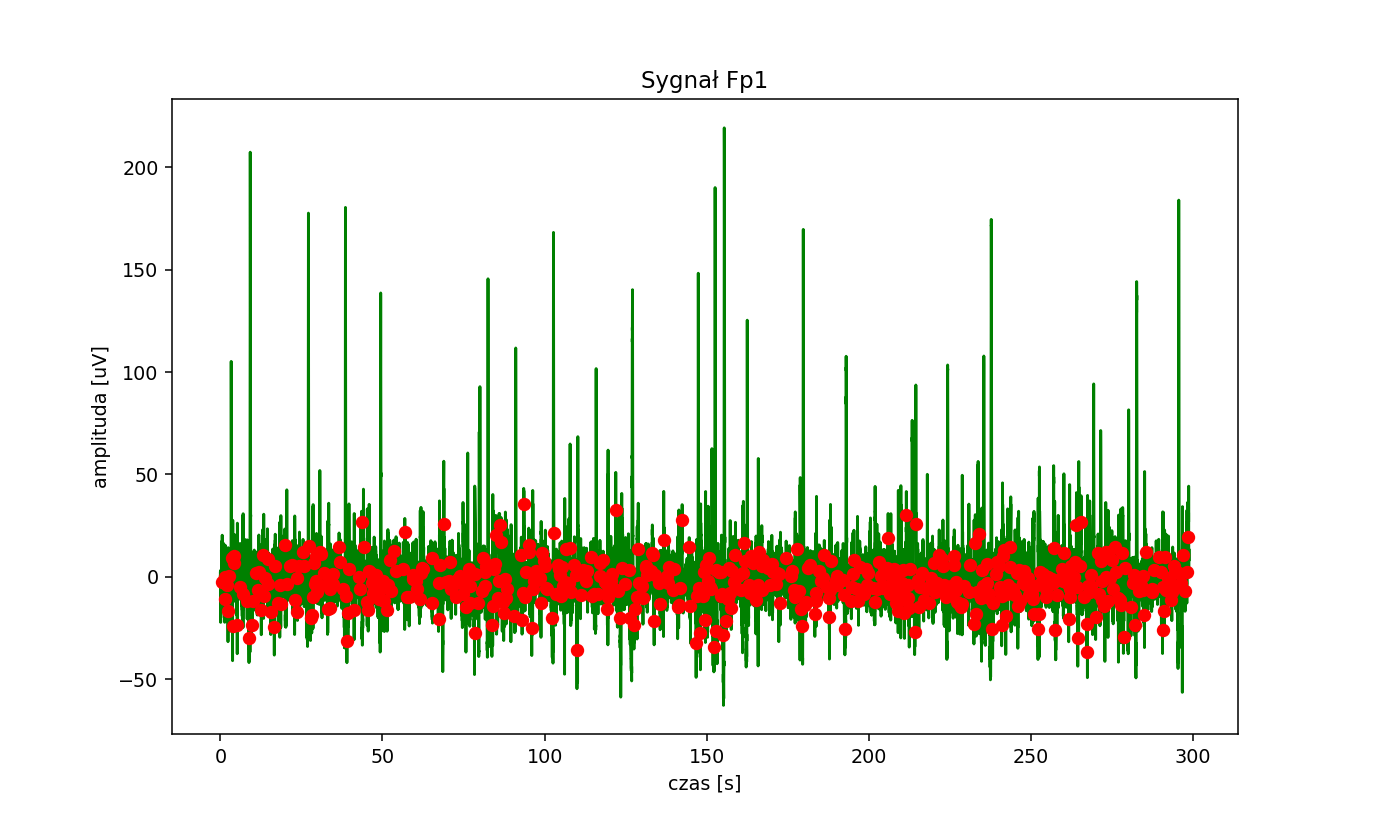

<IPython.core.display.Javascript object>


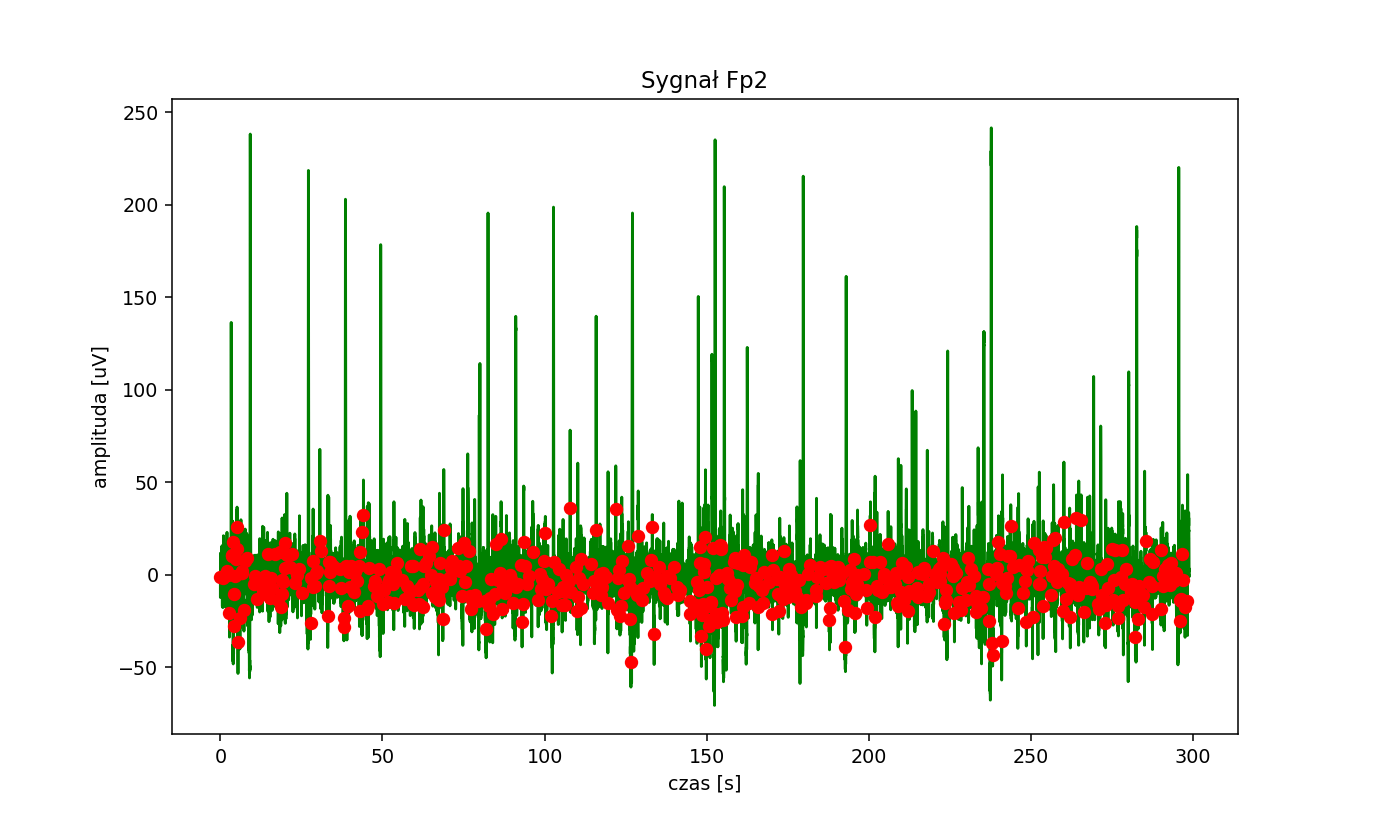

In [10]:
len_single_avrg = int(.3*Fs)
overlap = int(.02*Fs)
idx_to_diff = int(0.2 * Fs)
saccades = []
for ch in ["Fp1", "Fp2"]: #, "Fp2"]:
    sig = signal_from_mne.copy().pick_channels([ch])
    sigFp = sig.get_data().flatten() * 1000000 # zmieniam na mikrovolty

    mov_avrg = moving_average(sigFp, len_single_avrg , overlap)
    min_dff = get_min_diff(sigFp, idx_to_diff)
    max_dff = get_max_diff(sigFp, idx_to_diff)
    max_ampl = get_max_ampl(sigFp, mov_avrg)
    begs = find_saccades(sigFp, mov_avrg, Fs, min_dff, max_dff, max_ampl)
    saccades.append(begs)
    # to tylko poglądowo do oceny, jak działa algorytm
    fig = plt.figure(figsize=(10,6))
    plt.plot(t_vec, sigFp, 'g')
    #plt.plot(t_vec, mov_avrg, 'b')
    #plt.plot(t_vec[1:], np.diff(sigFp), color='orange')
    plt.xlabel('czas [s]')
    plt.ylabel('amplituda [uV]')
    plt.title(f'Sygnał {ch}')

    for i in range(len(begs)):
        plt.plot(t_vec[begs[i]], sigFp[begs[i]], "ro")
    plt.show()

Porównuję, czy w obu kanałach znaleziono sakkady z tolerancją 0.2*Fs

In [11]:
tolerance = 0.2 * Fs
saccades_final = saccades[0][(np.abs(saccades[1][:,None] - saccades[0]) < tolerance).any(0)]


## Sakkady w epokach

In [12]:
t_duration = 2
epoch_samples = t_duration * Fs


events, events_id = mne.events_from_annotations(signal_from_mne)


Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Response/E 00', 'Response/I 01', 'Response/I 02', 'Response/M 33', 'Response/P 101', 'Response/P 102', 'Response/P 103', 'Response/P 104', 'Response/P 105', 'Response/P 106', 'Response/P 107', 'Response/P 108', 'Response/P 109', 'Response/P 110', 'Response/P 111', 'Response/P 112', 'Response/P 201', 'Response/P 202', 'Response/P 203', 'Response/P 204', 'Response/P 205', 'Response/P 206', 'Response/P 207', 'Response/P 208', 'Response/P 209', 'Response/P 210', 'Response/P 211', 'Response/P 212', 'Response/T 01', 'Response/T 01 32', 'Response/T 02']


In [13]:
start_idxs = []
for event, key in zip(events, events_id.keys()):
    if "Response/P" in key:
        start_idxs.append(event[0])
start_idxs = np.array(start_idxs)
end_idxs = start_idxs + epoch_samples

In [14]:
saccades_in_epoch = []
for st, end in zip(start_idxs, end_idxs):
    chosen_saccades = (saccades_final > st) & (saccades_final < end)
    saccades_in_epoch.extend(saccades_final[chosen_saccades==True])

In [15]:
print(saccades_in_epoch)

[23560, 23785, 24378, 27820, 28202, 28590, 28945, 29163, 29442, 34863, 36920, 39366, 39646, 47891, 48786, 49741, 50310, 50582, 51440, 51657, 57690, 59273, 59526, 61621, 61850, 62490, 68869, 70480, 70815, 71188, 71411, 73428, 73983, 73984, 79542, 81688, 81952, 82667, 83996, 84627, 84930, 92808, 93051, 93343, 93549, 93964, 95327, 96311, 102383, 102866, 104227, 104363, 105221, 105663, 106437, 106667, 107380, 107743]
